# Question 1

In [346]:
%matplotlib inline

import random
import networkx as nx
import jieba

## BFS 搜索路径

In [62]:
BEIJING, CHANGCHUN, MULUMUQI, WUHAN, GUNAGHZOU, SHENZHEN, BANGKOK, SHANGHAI, NEWYORK = """
BEIJING CHANGCHUN MULUMUQI WUHAN GUANGZHOU SHENZHEN BANGKOK SHANGHAI NEWYORK
""".split()

connection = {
    CHANGCHUN: [BEIJING],
    MULUMUQI: [BEIJING], 
    BEIJING: [MULUMUQI, CHANGCHUN, WUHAN, SHENZHEN, NEWYORK],
    NEWYORK: [BEIJING, SHANGHAI],
    SHANGHAI: [NEWYORK, WUHAN],
    WUHAN: [SHANGHAI, BEIJING, GUNAGHZOU],
    GUNAGHZOU: [WUHAN, BANGKOK],
    SHENZHEN: [WUHAN, BANGKOK],
    BANGKOK: [SHENZHEN, GUNAGHZOU]
}

In [63]:
graph = nx.DiGraph(connection)

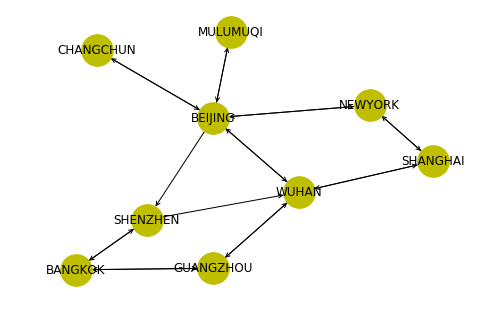

In [64]:
nx.draw(graph, with_labels=True, node_size=1000, node_color='y', arrowstyle='->', arrow_color='r')

In [65]:
def bfs_navigator(start, end, graph):
    paths = [[start]]
    searched = set()
    
    while paths:
        path = paths.pop(0)
        frontier = path[-1]
        
        if frontier in searched: continue
            
        successors = graph[frontier]
        for s in successors:
            if s == end:
                path.append(s)
                return ' -> '.join(path)
            paths.append(path+[s])
        
        paths = sorted(paths, key=len)
        searched.add(frontier)

In [66]:
bfs_navigator(CHANGCHUN, BANGKOK, connection)

'CHANGCHUN -> BEIJING -> SHENZHEN -> BANGKOK'

## 文本自动生成

In [67]:
grammar = """
sentence => noun_phrase verb_phrase 
noun_phrase => Article Adj* noun
Adj* => null | Adj Adj*
verb_phrase => verb noun_phrase
Article =>  一个 | 这个
noun =>   女人 |  篮球 | 桌子 | 小猫
verb => 看着   |  坐在 |  听着 | 看见
Adj =>   蓝色的 |  好看的 | 小小的
"""

In [68]:
decimal_grammar = """
expression = operator op operator
operator = num op num
num = 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | num num
op = + | - | * | /
"""

In [69]:
for line in grammar.split('\n'):
    print('line: ' + line)

line: 
line: sentence => noun_phrase verb_phrase 
line: noun_phrase => Article Adj* noun
line: Adj* => null | Adj Adj*
line: verb_phrase => verb noun_phrase
line: Article =>  一个 | 这个
line: noun =>   女人 |  篮球 | 桌子 | 小猫
line: verb => 看着   |  坐在 |  听着 | 看见
line: Adj =>   蓝色的 |  好看的 | 小小的
line: 


In [80]:
def parse_grammar(grammar_str, sep='=>'):
    grammar = {}
    
    for line in grammar_str.split('\n'):
        line = line.strip()
        if not line:
            continue
        rule, exprs = line.split(sep)
        
        grammar[rule.strip()] = [e.split() for e in exprs.split('|')]
    
    return grammar

In [81]:
parse_grammar(grammar)

{'Adj': [['蓝色的'], ['好看的'], ['小小的']],
 'Adj*': [['null'], ['Adj', 'Adj*']],
 'Article': [['一个'], ['这个']],
 'noun': [['女人'], ['篮球'], ['桌子'], ['小猫']],
 'noun_phrase': [['Article', 'Adj*', 'noun']],
 'sentence': [['noun_phrase', 'verb_phrase']],
 'verb': [['看着'], ['坐在'], ['听着'], ['看见']],
 'verb_phrase': [['verb', 'noun_phrase']]}

In [96]:
def gene(grammar_parsed, target='sentence'):
    if target not in grammar_parsed:
        return target
    return ''.join([gene(grammar_parsed, sub_t) for sub_t in random.choice(grammar_parsed[target]) if sub_t != 'null'])

In [138]:
grammar_parsed = parse_grammar(grammar)
gene(grammar_parsed)
grammar_parsed = parse_grammar(decimal_grammar, sep='=')
gene(grammar_parsed, target='expression')

'一个蓝色的小猫看见这个蓝色的小小的女人'

'96-3+4+9'

# Question 3

In [272]:
def is_variable(pat):
    return pat.startswith('?') and all(c.isalpha() for c in pat[1:])

In [140]:
def pat_match(pattern, saying):
    if is_variable(pattern[0]):
        return (pattern[0], saying[0])
    if pattern[0] != saying[0]:
        return False
    return pat_match(pattern[1:], saying[1:])

In [144]:
pat_match("?X equals ?X".split(), "2+2 equals 2+2".split())

('?X', '2+2')

In [189]:
def pat_match(pattern, saying):
    if len(pattern) != len(saying):
        return False
    if len(pattern) == 1 and is_variable(pattern[0]):
        return [(pattern[0], saying[0])]
    if len(pattern) == 1 and pattern[0] != saying[0]:
        return False
    if len(pattern) == 1 and pattern[0] == saying[0]:
        return []
    return  pat_match([pattern[0]], [saying[0]]) + pat_match(pattern[1:], saying[1:])

In [191]:
pat_match("?X greater than ?Y".split(), "3 greater than 2".split())

[('?X', '3'), ('?Y', '2')]

In [295]:
def pat_to_dict(patterns):
#     return dict(patterns)
    return {k:' '.join(v) if isinstance(v, list) else v for k, v in patterns}

In [296]:
def substitude(src_rule, parsed_rules):
    src_rule = list(src_rule)
    for i, symbol in enumerate(src_rule):
        if is_variable(symbol) and symbol in parsed_rules:
            src_rule[i] = parsed_rules[symbol]
    return src_rule

In [178]:
john_pat = pat_match('?P needs ?X'.split(), "John needs vacation".split())
john_pat = pat_to_dict(john_pat)
' '.join(substitude("Why does ?P need ?X ?".split(), john_pat))

'Why does John need vacation ?'

In [179]:
defined_patterns = {
    "I need ?X": ["Image you will get ?X soon", "Why do you need ?X ?"], 
    "My ?X told me something": ["Talk about more about your ?X", "How do you think about your ?X ?"]
}

In [204]:
def get_response(saying, rules=defined_patterns):
    """" please implement the code, to get the response as followings:
    
    >>> get_response('I need iPhone') 
    >>> Image you will get iPhone soon
    >>> get_response("My mother told me something")
    >>> Talk about more about your monther.
    """
    for rule in rules:
        try: 
            patterns = pat_match(rule.split(), saying.split())
            if not patterns:
                continue
            src_rule = random.choice(rules[rule])
            break
        except:
            continue
    else:
        return 'No Pattern FOUND!'
    
    patterns = pat_to_dict(patterns) 
    return ' '.join(substitude(src_rule.split(), patterns))
            

In [211]:
get_response('I need iPhone') 
#  Image you will get iPhone soon
get_response("My mother told me something")
#  Talk about more about your monther.

'Why do you need iPhone ?'

'Talk about more about your mother'

In [270]:
def is_pattern_segment(pattern):
    return pattern.startswith('?*') and all(c.isalpha() for c in pattern[2:])

In [271]:
is_pattern_segment('?*P')

True

In [327]:
def pat_match_with_segment(pattern, saying):
    
    if not pattern or not saying: return []
    
    for i, p in enumerate(pattern):
        if is_variable(p):
            return [(p, saying[0])] + pat_match_with_segment(pattern[i+1:], saying[1:])
        elif is_pattern_segment(p):
            last_index = get_index(pattern[i+1:], saying)
            if last_index is None:
                return []
            return [(p.replace('*', ''), saying[:last_index+1])] + pat_match_with_segment(pattern[i+1:], saying[last_index+1:])
        else:
            if p == saying[0]:
                return pat_match_with_segment(pattern[i+1:], saying[1:])
            else:
                return []

def get_index(pattern, saying):
    
    if not pattern:
        return len(saying) - 1 
    
    if not saying:
        return None
    
    for i, p in enumerate(pattern):
        if is_pattern_segment(p):
            pattern = pattern[:i]
            break
            
    for i, word in enumerate(saying):
        if pattern == saying[i: i+len(pattern)]:
            return i - 1
    return None

In [458]:
pat_match_with_segment(['?*x', 'hello', '?*y'], ['cat', 'hello', 'dog'])

[('?x', ['cat']), ('?y', ['dog'])]

In [298]:
get_index('is very good'.split(), 'ABC DEF is very good'.split())

1

In [299]:
pat_match_with_segment('?*P is very good and'.split(), "My dog is very good and".split())
[('?P', ['My', 'dog']), ('?X', ['my', 'cat', 'is', 'very', 'cute'])]

[('?P', ['My', 'dog'])]

[('?P', ['My', 'dog']), ('?X', ['my', 'cat', 'is', 'very', 'cute'])]

In [300]:
pat_match_with_segment('?*P is very good and ?*X'.split(), "My dog is very good and my cat is very cute".split())
[('?P', ['My', 'dog']), ('?X', ['my', 'cat', 'is', 'very', 'cute'])]

[('?P', ['My', 'dog']), ('?X', ['my', 'cat', 'is', 'very', 'cute'])]

[('?P', ['My', 'dog']), ('?X', ['my', 'cat', 'is', 'very', 'cute'])]

In [301]:
substitude("Why do you neeed ?X".split(), pat_to_dict(pat_match_with_segment('I need ?*X'.split(), 
                  "I need an iPhone".split())))

['Why', 'do', 'you', 'neeed', 'an iPhone']

In [303]:
substitude("Hi, how do you do?".split(), pat_to_dict(pat_match_with_segment('?*X hello ?*Y'.split(), 
                  "I am mike, hello ".split())))

['Hi,', 'how', 'do', 'you', 'do?']

In [548]:
rule_responses = {
    '?*x hello ?*y': ['How do you do', 'Please state your problem'],
    '?*x I want ?*y': ['what would it mean if you got ?y', 'Why do you want ?y', 'Suppose you got ?y soon'],
    '?*x if ?*y': ['Do you really think its likely that ?y', 'Do you wish that ?y', 'What do you think about ?y', 'Really-- if ?y'],
    '?*x no ?*y': ['why not?', 'You are being a negative', 'Are you saying \'No\' just to be negative?'],
    '?*x I was ?*y': ['Were you really', 'Perhaps I already knew you were ?y', 'Why do you tell me you were ?y now?'],
    '?*x I feel ?*y': ['Do you often feel ?y ?', 'What other feelings do you have?'],
    '?*x你好?*y': ['你好呀', '请告诉我你的问题'],
    '?*x我想?*y': ['你觉得?y有什么意义呢？', '为什么你想?y', '你可以想想你很快就可以?y了'],
    '?*x我想要?*y': ['?x想问你，你觉得?y有什么意义呢?', '为什么你想?y', '?x觉得... 你可以想想你很快就可以有?y了', '你看?x像?y不', '我看你就像?y'],
    '?*x喜欢?*y': ['喜欢?y的哪里？', '?y有什么好的呢？', '你想要?y吗？'],
    '?*x讨厌?*y': ['?y怎么会那么讨厌呢?', '讨厌?y的哪里？', '?y有什么不好呢？', '你不想要?y吗？'],
    '?*xAI?*y': ['你为什么要提AI的事情？', '你为什么觉得AI要解决你的问题？'],
    '?*x机器人?*y': ['你为什么要提机器人的事情？', '你为什么觉得机器人要解决你的问题？'],
    '?*x对不起?*y': ['不用道歉', '你为什么觉得你需要道歉呢?'],
    '?*x我记得?*y': ['你经常会想起这个吗？', '除了?y你还会想起什么吗？', '你为什么和我提起?y'],
    '?*x如果?*y': ['你真的觉得?y会发生吗？', '你希望?y吗?', '真的吗？如果?y的话', '关于?y你怎么想？'],
    '?*x我?*z梦见?*y':['真的吗? --- ?y', '你在醒着的时候，以前想象过?y吗？', '你以前梦见过?y吗'],
    '?*x妈妈?*y': ['你家里除了?y还有谁?', '嗯嗯，多说一点和你家里有关系的', '她对你影响很大吗？'],
    '?*x爸爸?*y': ['你家里除了?y和?x还有谁?', '嗯嗯，多说一点和你家里有关系的', '他对你影响很大吗？', '每当你想起你爸爸的时候， 你还会想起其他的吗?'],
    '?*x我愿意?*y': ['我可以帮你?y吗？', '你可以解释一下，为什么想?y'],
    '?*x我很难过，因为?*y': ['我听到你这么说， 也很难过', '?y不应该让你这么难过的'],
    '?*x难过?*y': ['我听到你这么说， 也很难过',
                 '不应该让你这么难过的，你觉得你拥有什么，就会不难过?',
                 '你觉得事情变成什么样，你就不难过了?'],
    '?*x就像?*y': ['你觉得?x和?y有什么相似性？', '?x和?y真的有关系吗？', '怎么说？'],
    '?*x和?*y都?*z': ['你觉得?z有什么问题吗?', '?z会对你有什么影响呢?'],
    '?*x和?*y一样?*z': ['你觉得?z有什么问题吗?', '?z会对你有什么影响呢?'],
    '?*x我是?*y': ['真的吗？', '?x想告诉你，或许我早就知道你是?y', '你为什么现在才告诉我你是?y'],
    '?*x我是?*y吗': ['如果你是?y会怎么样呢？', '你觉得你是?y吗', '如果你是?y，那一位着什么?'],
    '?*x你是?*y吗':  ['你为什么会对我是不是?y感兴趣?', '那你希望我是?y吗', '你要是喜欢， 我就会是?y'],
    '?*x你是?*y' : ['为什么你觉得我是?y'],
    '?*x因为?*y' : ['?y是真正的原因吗？', '你觉得会有其他原因吗?'],
    '?*x我不能?*y': ['你或许现在就能?*y', '如果你能?*y,会怎样呢？'],
    '?*x我觉得?*y': ['你经常这样感觉吗？', '除了到这个，你还有什么其他的感觉吗？'],
    '?*x我?*y你?*z': ['其实很有可能我们互相?y'],
    '?*x你为什么不?*y': ['你自己为什么不?y', '你觉得我不会?y', '等我心情好了，我就?y'],
    '?*x好的?*y': ['好的', '你是一个很正能量的人'],
    '?*x嗯嗯?*y': ['好的', '你是一个很正能量的人'],
    '?*x不嘛?*y': ['为什么不？', '你有一点负能量', '你说 不，是想表达不想的意思吗？'],
    '?*x不要?*y': ['为什么不？', '你有一点负能量', '你说 不，是想表达不想的意思吗？'],
    '?*x有些人?*y': ['具体是哪些人呢?'],
    '?*x有的人?*y': ['具体是哪些人呢?'],
    '?*x某些人?*y': ['具体是哪些人呢?'],
    '?*x每个人?*y': ['我确定不是人人都是', '你能想到一点特殊情况吗？', '例如谁？', '你看到的其实只是一小部分人'],
    '?*x所有人?*y': ['我确定不是人人都是', '你能想到一点特殊情况吗？', '例如谁？', '你看到的其实只是一小部分人'],
    '?*x总是?*y': ['你能想到一些其他情况吗?', '例如什么时候?', '你具体是说哪一次？', '真的---总是吗？'],
    '?*x一直?*y': ['你能想到一些其他情况吗?', '例如什么时候?', '你具体是说哪一次？', '真的---总是吗？'],
    '?*x或许?*y': ['你看起来不太确定'],
    '?*x可能?*y': ['你看起来不太确定'],
    '?*x他们是?*y吗？': ['你觉得他们可能不是?y？'],
    '?*x': ['很有趣', '请继续', '我不太确定我很理解你说的, 能稍微详细解释一下吗?']
}

## 问题1

In [328]:
def get_response(saying, rules=defined_patterns):
    
    for rule in rules:
        try: 
            patterns = pat_match_with_segment(rule.split(), saying.split())
#             print(patterns)
            if not patterns:
                continue
            src_rule = random.choice(rules[rule])
            break
        except:
            continue
    else:
        return 'No Pattern FOUND!'
    
    patterns = pat_to_dict(patterns) 
    return ' '.join(substitude(src_rule.split(), patterns))

In [339]:
get_response('I hello iPhone', rule_responses)
get_response('true if you are right', rule_responses)

'Please state your problem'

'What do you think about you are right'

## 问题2

In [372]:
jieba.add_word('?*x')
jieba.add_word('?*y')
# jieba.suggest_freq('?*x', tune=True)

In [538]:
def correct_rule(rule_cutted):
    rule_cutted = [r for r in rule_cutted if r.strip()]
    rule_ = []
    i = 0
    while i < len(rule_cutted):
        rule_cutted[i] = rule_cutted[i].strip()
        if not rule_cutted[i]: 
            i += 1
            continue
            
        symbol = ''.join(rule_cutted[i:i+3])
        if is_pattern_segment(symbol):
            rule_.append(symbol)
            i += 3
        else:
            rule_.append(rule_cutted[i])
            i += 1
            
            
    return rule_


def correct_rule2(rule_cutted):
    rule_cutted = [r for r in rule_cutted if r.strip()]
    rule_ = []
    i = 0
    while i < len(rule_cutted):
        rule_cutted[i] = rule_cutted[i].strip()
        if not rule_cutted[i]: 
            i += 1
            continue
            
        symbol = ''.join(rule_cutted[i:i+2])
        if is_variable(symbol):
            rule_.append(symbol)
            i += 2
        else:
            rule_.append(rule_cutted[i])
            i += 1
            
    return rule_

In [539]:
def get_response(saying, rules=defined_patterns):
    
    saying = jieba.lcut(saying, cut_all=False)
    saying = [word for word in saying if word.strip()]
    
#     jieba.add_word('?*x')
#     jieba.add_word('?*y')
#     jieba.suggest_freq("?*x", True)
#     jieba.suggest_freq("?*y", True)
    jieba.suggest_freq("AI", True)
    
    for rule in rules:
        
        # 合并被误分词的 '?*x', '?*y' 等
        
        rule_cutted = jieba.lcut(rule, cut_all=False)
        rule_ = correct_rule(rule_cutted)
#         rule_cutted = [r for r in rule_cutted if r.strip()]
#         rule_ = []
#         i = 0
#         while i < len(rule_cutted):
#             rule_cutted[i] = rule_cutted[i].strip()
#             if not rule_cutted[i]: 
#                 i += 1
#                 continue
#             symbol = ''.join(rule_cutted[i:i+3])
#             if is_pattern_segment(symbol):
#                 rule_.append(symbol)
#                 i += 3
#             else:
#                 rule_.append(rule_cutted[i])
#                 i += 1
#         print(rule_)
                
#         print(rule_)
#         print(saying)
        try: 
            patterns = pat_match_with_segment(rule_, saying)
#             patterns = pat_match_with_segment(rule.split(), saying.split())
#             print(patterns)
            if not patterns:
                continue
            src_rule = random.choice(rules[rule])
            break
        except:
#             print('here?')
            continue
    else:
        return 'No Pattern FOUND!'
    
    print(patterns)
    patterns = pat_to_dict(patterns) 
    src_rule = jieba.lcut(src_rule, cut_all=False)
    src_rule = correct_rule2(src_rule)
#     src_rule = [r for r in src_rule if r.strip()]
    print(src_rule)
    print(patterns)
    return ' '.join(substitude(src_rule, patterns))

In [540]:
get_response('cat hello dog', rule_responses)
# get_response('我的爸爸叫爷爷', rule_responses)

[('?x', ['cat']), ('?y', ['dog'])]
['How', 'do', 'you', 'do']
{'?x': 'cat', '?y': 'dog'}


'How do you do'

In [558]:
get_response('cat爸爸叫爷爷', rule_responses)

[('?x', ['cat']), ('?y', ['叫', '爷爷'])]
['你', '家里', '除了', '?y', '和', '?x', '还有', '谁', '?']
{'?x': 'cat', '?y': '叫 爷爷'}


'你 家里 除了 叫 爷爷 和 cat 还有 谁 ?'

## 问题3

无.

## 问题4

1.  
优点是没有硬编码规则, 较为灵活.   
缺点是没有足够的灵活, 虽然逻辑没有硬编码到代码中, 但仍然是通过映射, 写死在了文本中, 是否可通过机器学习, 将抽象层级进一步提高, 让机器自动从数据中学习规则, 达到真正的 Data driven; 另外可通过正则去匹配模式, 更加简洁强大.

2. 
数据驱动就是指从数据中学习规则、逻辑. 
本程序中主要体现在规则、逻辑不是硬编码到代码中, 而是通过问答映射数据的方式定义的.

3. 数据驱动是 AI 的核心. AI 是数据驱动的表现形式.